<a href="https://colab.research.google.com/github/MouadEttali/Machine-Learning-Study-/blob/main/Test_technique_Modjo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Challenge
**The purpose of this notebook is to document step by step the process of a rigorous machine learning application and classify a number of calls into their respective Tags(classes)** 


we'll start by implementing the next steps in order to get our desired outcome:


1.   Exploratory Data Analysis and Feature Engineering.
3.   Choosing Candidate Models and preparing data for training.
4.   Training the models and evaluating them.



In [1]:
#Importing the Libraries
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
!pip install --upgrade scikit-learn #restart runtime after this first cell to upgrade the scikit learn library

     |████████████████████████████████| 23.2 MB 1.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
#Loading the data
df = pd.read_csv('/content/drive/MyDrive/DS-challenge-dataset.csv')
df.shape

(3786, 17)



# 1.  Exploratory Data Analysis and Feature Engineering.




## Pre-cleaning

In [3]:
df.head(5).T # My Personal way of exploring the data by showing Columns in rows for easier reading and intial comprehension


,0,1,2,3,4
id,5288,5285,5282,5277,5279
duration,657.344,205.479,1607.1,249.913,1948.75
date,2021-10-11 12:02:24,2021-10-08 18:04:23,2021-10-08 11:03:51,2021-10-07 18:10:25,2021-10-07 18:00:00
userId,14,63,18,23,8
modifiedById,NaN,NaN,NaN,NaN,NaN
phoneProvider,zoom,aircall,zoom,aircall,google
direction,outbound,outbound,outbound,outbound,outbound
mediaType,video,audio,video,audio,video
dealId,543,NaN,488,NaN,NaN
userTalkRatio,0.292525,0.452397,0.483552,0.452936,0.315928


In [4]:
#before anything let's get rid of the huge decimals by rounding up to 2 numbers after the decimal
df = df.round(2)# this is just musch cleaner and easier to visualize.
df 

,id,duration,date,userId,modifiedById,phoneProvider,direction,mediaType,dealId,userTalkRatio,longestContactMonologue,patience,interactionSpeed,role,teams,contacts,tag
0,5288,657.34,2021-10-11 12:02:24,14,NaN,zoom,outbound,video,543.0,0.29,80.30,0.77,3.01,admin,{Sales},1.0,Client Follow Up
1,5285,205.48,2021-10-08 18:04:23,63,NaN,aircall,outbound,audio,NaN,0.45,23.71,0.41,8.18,admin,{Sales},1.0,Cold Call
2,5282,1607.10,2021-10-08 11:03:51,18,NaN,zoom,outbound,video,488.0,0.48,57.84,0.28,4.59,admin,{Account Manager},1.0,Client Follow Up
3,5277,249.91,2021-10-07 18:10:25,23,NaN,aircall,outbound,audio,NaN,0.45,43.19,1.77,5.52,admin,{Sales},1.0,Unscheduled Follow up
4,5279,1948.75,2021-10-07 18:00:00,8,NaN,google,outbound,video,NaN,0.32,267.82,0.47,2.03,admin,{Sales},2.0,1st Call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781,6,4448.00,2020-05-18 12:01:18,1,NaN,zoom,outbound,audio,NaN,0.26,198.98,1.65,2.01,admin,{Sales},1.0,Demo
3782,5,3756.00,2020-05-14 14:00:35,3,NaN,zoom,outbound,audio,NaN,0.45,257.12,0.83,1.71,admin,"{Account Manager,Product}",3.0,Other
3783,4,2139.00,2020-05-14 10:04:10,1,NaN,zoom,outbound,audio,NaN,0.30,153.16,1.30,2.44,admin,{Sales},1.0,1st Call
3784,2,2151.00,2020-05-12 15:04:06,1,NaN,zoom,outbound,audio,NaN,0.42,120.53,0.73,2.57,admin,{Sales},2.0,1st Call


### Column Types coherence 



**Here we check for the datatypes because sometimes some numeric columns would be stored as a string or object, if in that case, we have to convert that string to the integer data only then we can plot the data via  graphs later.**

In [5]:
df.dtypes

id                           int64
duration                   float64
date                        object
userId                       int64
modifiedById               float64
phoneProvider               object
direction                   object
mediaType                   object
dealId                     float64
userTalkRatio              float64
longestContactMonologue    float64
patience                   float64
interactionSpeed           float64
role                        object
teams                       object
contacts                   float64
tag                         object
dtype: object

**I noticed here that some columns are of type object ( i.e strings ) which means we'll have to either encode them or extract valuable information from them in order to pass through our predictive pipeline.**

In [6]:
df.describe()

,id,duration,userId,modifiedById,dealId,userTalkRatio,longestContactMonologue,patience,interactionSpeed,contacts
count,3786.000000,3786.000000,3786.000000,780.000000,1604.000000,3786.000000,3786.000000,3786.000000,3786.000000,3785.000000
mean,2512.849445,1539.603096,12.104068,13.371795,275.250000,0.412274,119.351561,1.411725,2.842039,1.612682
std,1633.854007,1093.167973,9.140717,10.343409,172.546996,0.198329,208.211269,11.907283,1.621236,1.733286
min,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1062.250000,574.682500,8.000000,8.000000,129.000000,0.300000,38.532500,0.410000,1.920000,1.000000
50%,2084.500000,1531.585000,13.000000,14.000000,253.500000,0.440000,74.375000,0.640000,2.780000,1.000000
75%,4104.750000,2229.597500,17.000000,17.000000,413.000000,0.550000,127.697500,0.970000,3.780000,2.000000
max,5288.000000,10127.000000,63.000000,67.000000,645.000000,1.320000,3040.520000,470.640000,10.470000,44.000000


**let's start by extracting all we can from the date column.**


In [7]:
# First I'll convert the type to datetime
df['date'] = pd.to_datetime(df['date'], 
 format = '%Y-%m-%d %H:%M:%S')
df.date.head()

0   2021-10-11 12:02:24
1   2021-10-08 18:04:23
2   2021-10-08 11:03:51
3   2021-10-07 18:10:25
4   2021-10-07 18:00:00
Name: date, dtype: datetime64[ns]

**My rational**here is that since these are phone calls we're working with,the time of the day and the month of the year might affect the **underlying sentiments** behind the call. For example some clients might be in a bad mood receiving a call during **the first or last hour of their workday**, or maybe our client is an auditing firm and their workload is much more subtantial **between January and Mars**. this is purely out of intuition however it also does help with our main task of dealing with the string data types

In [8]:
# Then let's get the important data into respective columns
df['month']= df['date'].dt.month
df['hour']= df['date'].dt.hour
df['dayOfWeek']= df['date'].dt.dayofweek
df.head()

,id,duration,date,userId,modifiedById,phoneProvider,direction,mediaType,dealId,userTalkRatio,longestContactMonologue,patience,interactionSpeed,role,teams,contacts,tag,month,hour,dayOfWeek
0,5288,657.34,2021-10-11 12:02:24,14,NaN,zoom,outbound,video,543.0,0.29,80.30,0.77,3.01,admin,{Sales},1.0,Client Follow Up,10,12,0
1,5285,205.48,2021-10-08 18:04:23,63,NaN,aircall,outbound,audio,NaN,0.45,23.71,0.41,8.18,admin,{Sales},1.0,Cold Call,10,18,4
2,5282,1607.10,2021-10-08 11:03:51,18,NaN,zoom,outbound,video,488.0,0.48,57.84,0.28,4.59,admin,{Account Manager},1.0,Client Follow Up,10,11,4
3,5277,249.91,2021-10-07 18:10:25,23,NaN,aircall,outbound,audio,NaN,0.45,43.19,1.77,5.52,admin,{Sales},1.0,Unscheduled Follow up,10,18,3
4,5279,1948.75,2021-10-07 18:00:00,8,NaN,google,outbound,video,NaN,0.32,267.82,0.47,2.03,admin,{Sales},2.0,1st Call,10,18,3


### Dealing with Null Values

In [9]:
# Let's take a look at all the null values, some of them tend to hide, others like to shine throughout the data. 
df.isnull().sum()

id                            0
duration                      0
date                          0
userId                        0
modifiedById               3006
phoneProvider                 0
direction                     0
mediaType                     0
dealId                     2182
userTalkRatio                 0
longestContactMonologue       0
patience                      0
interactionSpeed              0
role                          0
teams                        58
contacts                      1
tag                           0
month                         0
hour                          0
dayOfWeek                     0
dtype: int64

**One thing that's been on my mind since the first exploration are these Null values mainly in the 'modifiedById' and 'dealId' , let's focus our scope on them and see what we can do anything about it**

In [10]:
# A temporary DF to better visualize our missing values
temp = df[df.columns].isnull().sum()
temp = temp.to_frame('missing_values')
temp['percentage_of_missing_values'] = (df[df.columns].isnull().sum()/df.shape[0])*100
temp = temp.round(2)[temp.percentage_of_missing_values !=0]
temp

,missing_values,percentage_of_missing_values
modifiedById,3006,79.40
dealId,2182,57.63
teams,58,1.53
contacts,1,0.03


**Okey, now that I have a good idea on what needs to be done in every column in regards to the Null values, let's start with the easiest issues for teams and contacts then we'll move to more drastic measures for the modifiedById and DealId columns**

In [11]:
def get_most_frequent_value(Pandascolumn):
    value = df[Pandascolumn][df[Pandascolumn].notnull()].value_counts().index[0]
    numberOfOccurence = df[Pandascolumn][df[Pandascolumn].notnull()].value_counts().max()
    print(f" The value '{value}' occured '{numberOfOccurence}' times.")
    return value

**The function above returns the most frequent value (their mode) in a certain column, using these two values I'll fix the null problems in the contacts and teams columns.**

In [12]:
most_frequent_contact = get_most_frequent_value('contacts')
most_frequent_team = get_most_frequent_value('teams')

 The value '1.0' occured '2761' times.
 The value '{Sales}' occured '3246' times.


In [13]:
print(most_frequent_team)

{Sales}


In [14]:
# replacing na values in contacts and teams with their respective mode
df["contacts"].fillna(most_frequent_contact, inplace = True)
df["teams"].fillna(most_frequent_team, inplace = True)

**In the missing rows table below we realize that DealId column is 58% missing values, and modifiedById is almost 80% missing values! this is more than enough for us to take the harsh decision of dropping the columns in this use case.**

In [15]:
temp

,missing_values,percentage_of_missing_values
modifiedById,3006,79.40
dealId,2182,57.63
teams,58,1.53
contacts,1,0.03


 ### Dropping columns that won't affect the prediction

**Let's move on now to choosing the other columns that are counterproductive for the prediction task, the 'id'  and 'userId' columns mainly is basically just noise**

**The Date columne since we've already extracted the most valuable data out of it ( ie ,hour , month , day of the week ) we can drop that as well.**

In [16]:
#dropping the columns with a huge number of missings values
df = df.drop(['id','userId','date','modifiedById','dealId'],axis=1)
df

,duration,phoneProvider,direction,mediaType,userTalkRatio,longestContactMonologue,patience,interactionSpeed,role,teams,contacts,tag,month,hour,dayOfWeek
0,657.34,zoom,outbound,video,0.29,80.30,0.77,3.01,admin,{Sales},1.0,Client Follow Up,10,12,0
1,205.48,aircall,outbound,audio,0.45,23.71,0.41,8.18,admin,{Sales},1.0,Cold Call,10,18,4
2,1607.10,zoom,outbound,video,0.48,57.84,0.28,4.59,admin,{Account Manager},1.0,Client Follow Up,10,11,4
3,249.91,aircall,outbound,audio,0.45,43.19,1.77,5.52,admin,{Sales},1.0,Unscheduled Follow up,10,18,3
4,1948.75,google,outbound,video,0.32,267.82,0.47,2.03,admin,{Sales},2.0,1st Call,10,18,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3781,4448.00,zoom,outbound,audio,0.26,198.98,1.65,2.01,admin,{Sales},1.0,Demo,5,12,0
3782,3756.00,zoom,outbound,audio,0.45,257.12,0.83,1.71,admin,"{Account Manager,Product}",3.0,Other,5,14,3
3783,2139.00,zoom,outbound,audio,0.30,153.16,1.30,2.44,admin,{Sales},1.0,1st Call,5,10,3
3784,2151.00,zoom,outbound,audio,0.42,120.53,0.73,2.57,admin,{Sales},2.0,1st Call,5,15,1


In [17]:
# Rechecking our work so far
df.isnull().sum()

duration                   0
phoneProvider              0
direction                  0
mediaType                  0
userTalkRatio              0
longestContactMonologue    0
patience                   0
interactionSpeed           0
role                       0
teams                      0
contacts                   0
tag                        0
month                      0
hour                       0
dayOfWeek                  0
dtype: int64

**Checking for duplicate rows**

In [18]:
# Rows containing duplicate data
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (1, 15)


In [19]:
df = df.drop_duplicates()

**Now that our data is cleaned, we need to prepare it for our machine learning pipeline, mainly with encoding our categorical data in columns  	phoneProvider 	direction 	mediaType  role  teams  tag**

## EDA

let's do some basic plots to get a rough idea about the relationship between our explicative variables and the target variable

### Checking for outliers

#### BoxPlots for numeric features

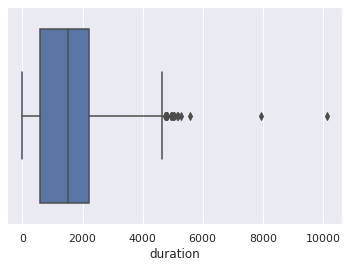

In [20]:
sns.boxplot(x=df['duration'])

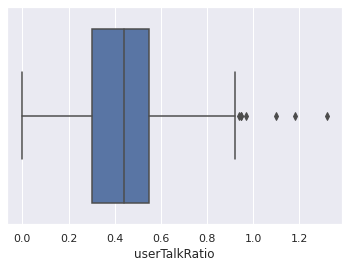

In [21]:
sns.boxplot(x=df['userTalkRatio'])

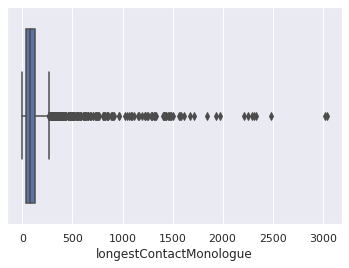

In [22]:
sns.boxplot(x=df['longestContactMonologue'])

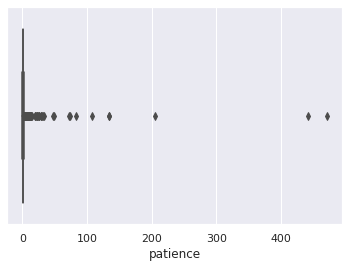

In [23]:
sns.boxplot(x=df['patience'])

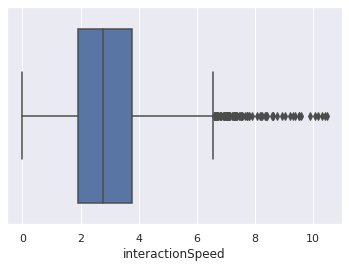

In [24]:
sns.boxplot(x=df['interactionSpeed'])

**Despite all these outliers, as much as I’d like to, it is not acceptable to drop an observation just because it is an outlier.  They can be legitimate observations and are sometimes the most interesting ones.  It’s important to investigate the nature of the outlier before deciding.**

#### ScatterPlots for numeric features

**The goal here is to see how the features describe the target variable and more importantly if these outliers might mess up our analysis**

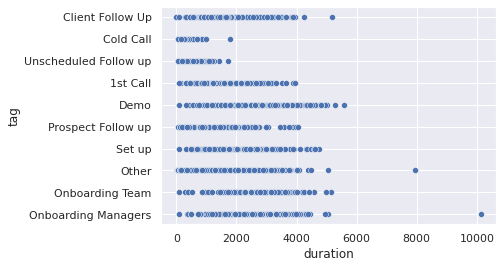

In [25]:
sns.scatterplot(x="duration",
                    y="tag",
                    data=df)

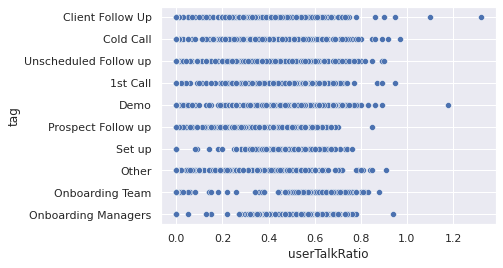

In [26]:
sns.scatterplot(x="userTalkRatio",
                    y="tag",
                    data=df)

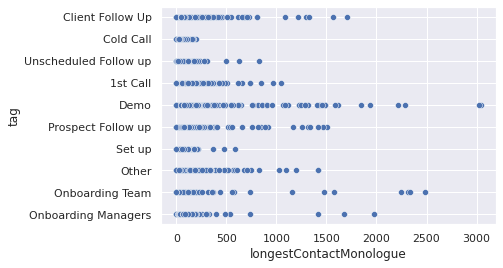

In [27]:
sns.scatterplot(x="longestContactMonologue",
                    y="tag",
                    data=df)

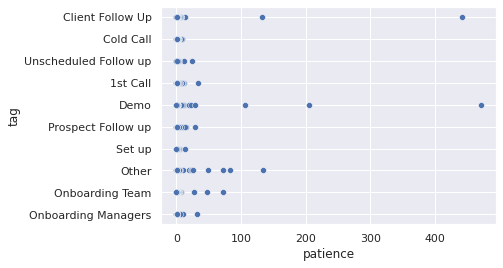

In [28]:
sns.scatterplot(x="patience",
                    y="tag",
                    data=df)

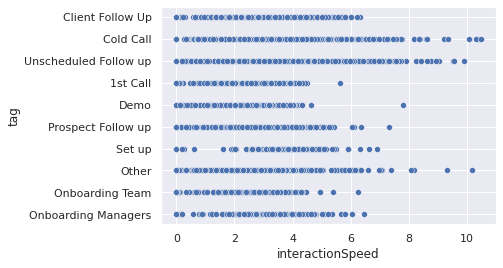

In [29]:
sns.scatterplot(x="interactionSpeed",
                    y="tag",
                    data=df)

**Judging from these scatterplots, I believe the outliers aren't noise or mistakes in data collection, I believe these are legitimate data points that might have the secret to succefully classifying our target variable and thus I'll make the decision of keeping them.**

### Checking for Class Imbalance

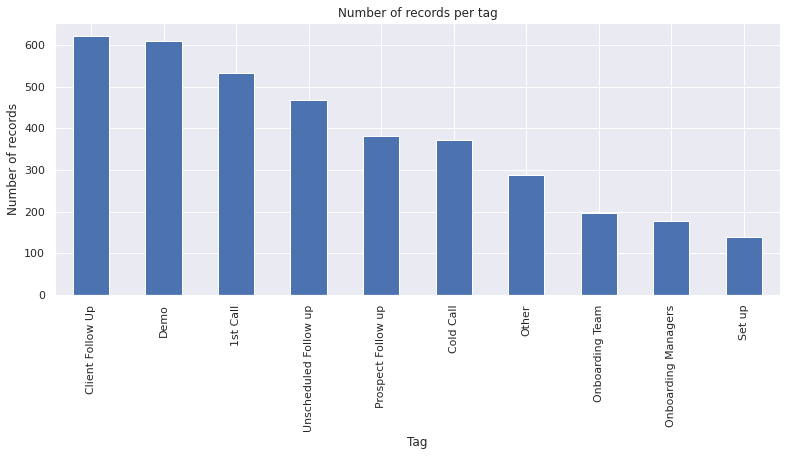

In [30]:
# let's plot a histogram for that, checking the number of occurences of every tag
df.tag.value_counts().nlargest(40).plot(kind='bar', figsize=(13,5))
plt.title('Number of records per tag')
plt.ylabel('Number of records')
plt.xlabel('Tag');

**there is a slight class imbalance but it is not worriying nor alarming, we'll decide if we want to treat it after training our first model depending on the accuracy resulted**

### Checking for Correlation between our Variables

,duration,userTalkRatio,longestContactMonologue,patience,interactionSpeed,contacts,month,hour,dayOfWeek
duration,1.000000,0.220946,0.283097,0.043369,-0.187552,0.305065,0.161325,-0.062703,0.004335
userTalkRatio,0.220946,1.000000,-0.230056,-0.085201,0.291819,0.110730,-0.002542,-0.027202,-0.008060
longestContactMonologue,0.283097,-0.230056,1.000000,0.251942,-0.237399,0.163310,0.042359,0.014833,0.020443
patience,0.043369,-0.085201,0.251942,1.000000,-0.067078,0.053190,-0.013654,-0.001298,0.009114
interactionSpeed,-0.187552,0.291819,-0.237399,-0.067078,1.000000,-0.128542,-0.027816,0.039252,0.002023
contacts,0.305065,0.110730,0.163310,0.053190,-0.128542,1.000000,0.008234,-0.016402,0.025031
month,0.161325,-0.002542,0.042359,-0.013654,-0.027816,0.008234,1.000000,-0.009105,-0.013679
hour,-0.062703,-0.027202,0.014833,-0.001298,0.039252,-0.016402,-0.009105,1.000000,-0.107986
dayOfWeek,0.004335,-0.008060,0.020443,0.009114,0.002023,0.025031,-0.013679,-0.107986,1.000000


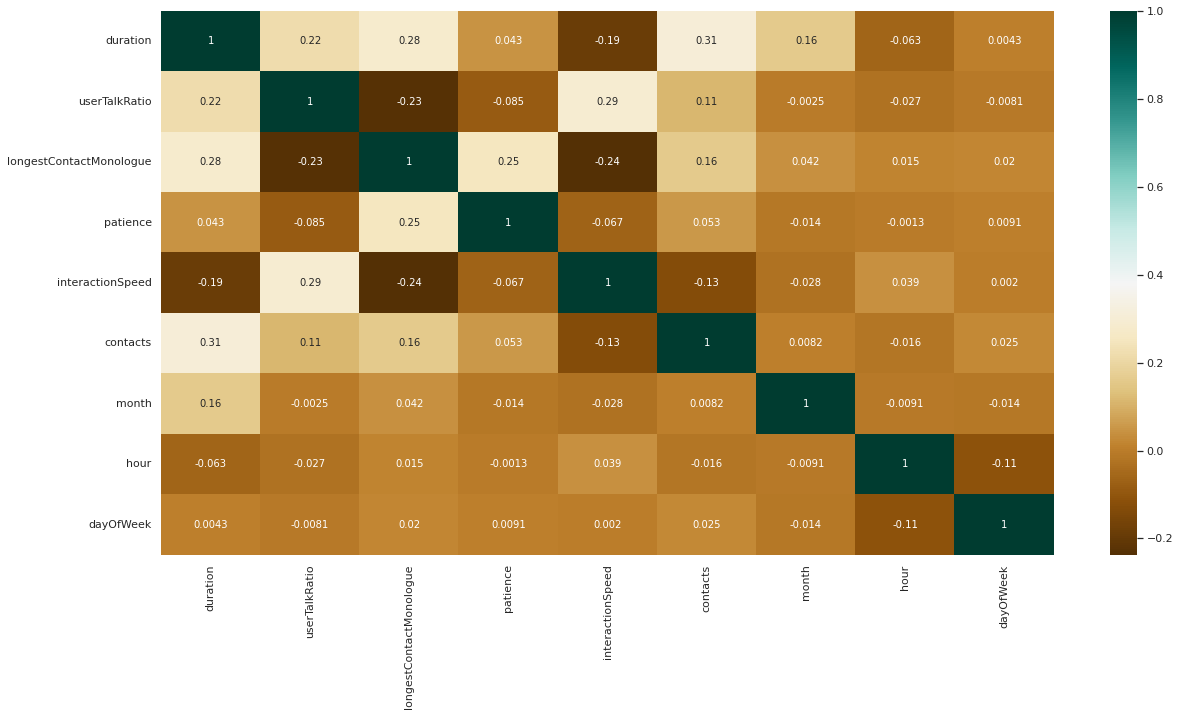

In [31]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

**Very weak correlation between our variables**

# 2.  Model choice and data preparation for training.

**Let's check how our data explains our target variable using a PCA analysis, here i'll use FAMD since i have mixed Categorical and Continuous data Types**

In [32]:
pip install prince

In [33]:
import prince
import pprint
## Instantiate FAMD object
famd = prince.FAMD(
     n_components=10,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='auto',       ## Can be "auto", 'sklearn', 'fbpca'
     random_state=42)

## Fit FAMD object to data 
famd = famd.fit(df.drop('tag', axis=1)) ## Exclude target variable "tag"

## Inspect principal dimensions
pp = pprint.PrettyPrinter()
pp.pprint(famd.explained_inertia_) 

array([0.1432551 , 0.09238807, 0.06529945, 0.06298601, 0.06019742,
       0.05458576, 0.05009624, 0.04962759, 0.04566675, 0.04241022])


We interpret this result as a lack of colinearity between the variables and we should use them all for our analysis

we can try a linear model such as logistic regression and see how it fares 
against more commun models for this task ( such as random forest , svm , xgboost )  

## Splitting data and preparing it for training

In [34]:
y = df['tag']
X = df
X.shape,y.shape

((3785, 15), (3785,))

### Encoding and transforming columns based on data types

In [35]:
#Selectin numerical and categorical Columns
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df)
categorical_columns = categorical_columns_selector(df)

In [36]:
#print to see if it's correct
numerical_columns,categorical_columns

(['duration',
  'userTalkRatio',
  'longestContactMonologue',
  'patience',
  'interactionSpeed',
  'contacts',
  'month',
  'hour',
  'dayOfWeek'],
 ['phoneProvider', 'direction', 'mediaType', 'role', 'teams', 'tag'])

In [197]:
#Choosing our encoder for the categorical columns and the standard Scaler to standardize numerical columns
from sklearn.preprocessing import OneHotEncoder, StandardScaler 

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

**Standardization has the purpose of putting our numerical columns in the same range of values (0 to 1) so as to avoid bias in favor of columns with higher values ( for example values like the column duration are much higher than those in the column patience by a huge factor that could mess up our predictions )**

In [38]:
#Now, we create the transformer and associate each of these preprocessors with their respective columns.
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

# 3.  Model training and evaluation.

## Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(preprocessor, LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=500))

In [40]:
from sklearn import set_config
set_config(display='diagram')
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['phoneProvider', 'direction',
                                                   'mediaType', 'role', 'teams',
                                                   'tag']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['duration', 'userTalkRatio',
                                                   'longestContactMonologue',
                                                   'patience',
                                                   'interactionSpeed',
                                                   'contacts', 'month', 'hour',
                                                   'dayOfWeek'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=500, multi_class='multinomial'))])

In [41]:
from sklearn.model_selection import train_test_split
# splitting the data with 25% of the rows as the test data.
data_train, data_test, target_train, target_test = train_test_split(
    X, y,test_size=0.25, random_state=42)

In [42]:
target_train.head()

2030                 Other
1695      Client Follow Up
977        Onboarding Team
2015    Prospect Follow up
848     Prospect Follow up
Name: tag, dtype: object

In [43]:
_ = model.fit(data_train, target_train)

In [44]:
model.predict(data_test)[:10]

array(['Demo', 'Set up', '1st Call', 'Cold Call', 'Other',
       'Client Follow Up', 'Demo', 'Other', 'Prospect Follow up', 'Demo'],
      dtype=object)

In [45]:
target_test[:10]

1780                  Demo
1165                Set up
263               1st Call
2685             Cold Call
806                  Other
1404      Client Follow Up
605                   Demo
1653                 Other
3319    Prospect Follow up
1874                  Demo
Name: tag, dtype: object

In [46]:
model.score(data_test, target_test)

1.0

This seems a little worriying, let's check if the test data is somehow a sub dataframe of train data .

In [47]:
#this is similar to a sql inner join where im trying to see the matching records between my test and training data
temp = data_train.merge(data_test, how = 'inner' ,indicator=False)
temp

,duration,phoneProvider,direction,mediaType,userTalkRatio,longestContactMonologue,patience,interactionSpeed,role,teams,contacts,tag,month,hour,dayOfWeek


Clearly there are none.

to be even more sure i checked for the duplicates all the way from the original dataframe.

In [48]:
df[df.duplicated()==True].value_counts()

Series([], dtype: int64)

let's try with cross validation now to test against multiple " test data " 

In [49]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X,y, cv=5,scoring='accuracy',error_score='raise').mean()

0.9994715984147952

Okey so this clearly is a problem and our first reflex is to make hypotheses to explain this accuracy score

1.   Class imbalance.
2.   Model is too complex due to the encoding of the categorical variables.


## Decision Tree

in order to fix these two issues, i'll use a decision tree model that takes into account only numerical features for now, find the most pertinant numerical features as well as take into account the class weight and countermeasuring the class imabalances.

In [51]:
preprocessor = ColumnTransformer(
    ('standard-scaler', numerical_preprocessor, numerical_columns))

In [91]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(class_weight = 'balanced' ,max_depth = 5 ,min_samples_split=6) # accounting for class imbalance
model2 = make_pipeline(numerical_preprocessor, clf)

In [92]:
from sklearn import set_config
set_config(display='diagram')
model2

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                                        min_samples_split=6))])

In [93]:
X =  X[numerical_columns]

In [94]:
data_train, data_test, target_train, target_test = train_test_split(
   X, y,test_size=0.25, random_state=42)

In [95]:
_ = model2.fit(data_train, target_train)
model2.predict(data_test)[:10]

array(['1st Call', 'Set up', '1st Call', 'Cold Call', 'Set up',
       'Onboarding Managers', 'Demo', 'Set up', 'Prospect Follow up',
       'Onboarding Team'], dtype=object)

In [96]:
predictions = model2.predict(data_test)

In [97]:
from sklearn.metrics import accuracy_score, confusion_matrix , precision_score , classification_report,recall_score
accuracy_score(target_test,predictions)

0.3717001055966209

In [99]:
precision_score(target_test,predictions,average='weighted')

0.35705231048308983

In [100]:
recall_score(target_test,predictions,average='weighted')

0.3717001055966209

In [101]:
print(classification_report(target_test,predictions,target_names=target_train.value_counts().index))

                       precision    recall  f1-score   support

                 Demo       0.34      0.57      0.43       138
     Client Follow Up       0.12      0.01      0.01       163
             1st Call       0.58      0.59      0.59        91
Unscheduled Follow up       0.54      0.49      0.51       146
   Prospect Follow up       0.14      0.23      0.17        48
            Cold Call       0.60      0.56      0.58        52
                Other       0.16      0.13      0.14        78
      Onboarding Team       0.24      0.32      0.28        82
  Onboarding Managers       0.10      0.23      0.13        31
               Set up       0.56      0.54      0.55       118

             accuracy                           0.37       947
            macro avg       0.34      0.37      0.34       947
         weighted avg       0.36      0.37      0.35       947



This algorithm maybe not the most optimal one but we're using it here for interprebality, finding the most important features 

### Feature selection

In [65]:
feature_importance = pd.DataFrame(clf.feature_importances_,index= numerical_columns)
feature_importance

,0
duration,0.642410
userTalkRatio,0.050814
longestContactMonologue,0.029312
patience,0.010175
interactionSpeed,0.114496
contacts,0.071985
month,0.073631
hour,0.000000
dayOfWeek,0.007177


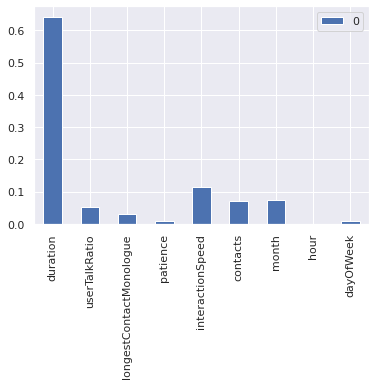

In [62]:
feature_importance.plot(kind='bar')

We can see the duration is the most important and the hour and day of the week being the least important. 

## Random Forest

Now i'll move on to a random forest model , again taking into account only pertinant numerical features. and i'll tune the model with grid search to get the highet evaluations from it

In [113]:
from sklearn.ensemble import RandomForestClassifier
model_3 = RandomForestClassifier( random_state = 42)

In [106]:
X = X.drop(['hour','dayOfWeek'], axis=1)
X.head()

,duration,userTalkRatio,longestContactMonologue,patience,interactionSpeed,contacts,month
0,657.34,0.29,80.30,0.77,3.01,1.0,10
1,205.48,0.45,23.71,0.41,8.18,1.0,10
2,1607.10,0.48,57.84,0.28,4.59,1.0,10
3,249.91,0.45,43.19,1.77,5.52,1.0,10
4,1948.75,0.32,267.82,0.47,2.03,2.0,10


In [114]:
from sklearn.model_selection import train_test_split
# splitting the data with 25% of the rows as the test data.
data_train, data_test, target_train, target_test = train_test_split(
    X, y,test_size=0.25, random_state=42)

In [125]:
_ = model_3.fit(data_train, target_train)
predictions = model_3.predict(data_test)

In [126]:
print(classification_report(target_test,predictions,target_names=target_train.value_counts().index))

                       precision    recall  f1-score   support

                 Demo       0.39      0.49      0.44       138
     Client Follow Up       0.36      0.42      0.38       163
             1st Call       0.61      0.54      0.57        91
Unscheduled Follow up       0.49      0.64      0.56       146
   Prospect Follow up       0.10      0.02      0.03        48
            Cold Call       0.54      0.50      0.52        52
                Other       0.42      0.06      0.11        78
      Onboarding Team       0.30      0.30      0.30        82
  Onboarding Managers       0.40      0.19      0.26        31
               Set up       0.53      0.65      0.59       118

             accuracy                           0.44       947
            macro avg       0.41      0.38      0.38       947
         weighted avg       0.43      0.44      0.42       947



In [127]:
accuracy_score(predictions, target_test)

0.4424498416050686

### Grid Search CV for hyperparameter tuning

In [117]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [119]:
from sklearn.model_selection import GridSearchCV
CV_rfc = GridSearchCV(estimator=model_3, param_grid=param_grid, cv= 5)
CV_rfc.fit(data_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [120]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

In [133]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=8, criterion='entropy')

In [134]:
_ = rfc1.fit(data_train, target_train)
predictions = rfc1.predict(data_test)

In [135]:
print(classification_report(target_test,predictions,target_names=target_train.value_counts().index))

                       precision    recall  f1-score   support

                 Demo       0.41      0.55      0.47       138
     Client Follow Up       0.39      0.44      0.41       163
             1st Call       0.63      0.51      0.56        91
Unscheduled Follow up       0.49      0.72      0.58       146
   Prospect Follow up       0.33      0.02      0.04        48
            Cold Call       0.56      0.56      0.56        52
                Other       0.33      0.03      0.05        78
      Onboarding Team       0.38      0.29      0.33        82
  Onboarding Managers       0.50      0.03      0.06        31
               Set up       0.54      0.75      0.63       118

             accuracy                           0.47       947
            macro avg       0.46      0.39      0.37       947
         weighted avg       0.45      0.47      0.43       947



In [136]:
accuracy_score(predictions, target_test)

0.4699049630411827

## Random Forest with categorical Features

It's not much of a difference in accuracy score but the it seems recall got a lift overall 

now that we need to see how the categorical columns will be introduced to simultaneously maintain the integrity of the model, and raise its metrics.

Let's use chi-square test to understand relationship between categorical variables and target variable

In [137]:
from scipy.stats import chi2_contingency

In [145]:
data = [{'phoneProvider': chi2_contingency(pd.crosstab(df['tag'], df['phoneProvider']))[1]
, 'direction': chi2_contingency(pd.crosstab(df['tag'], df['direction']))[1]
, 'mediaType':chi2_contingency(pd.crosstab(df['tag'], df['mediaType']))[1]
,'role':chi2_contingency(pd.crosstab(df['tag'], df['role']))[1]
,'teams':chi2_contingency(pd.crosstab(df['tag'], df['teams']))[1]
}]  

In [147]:
P_values = pd.DataFrame(data,index=['P-value'])
P_values

,phoneProvider,direction,mediaType,role,teams
P-value,0.0,1.558878e-71,0.0,1.0,1.969402e-250


P values for features direction, teams , phoneProvider and mediaType are very low. So we can reject our Null Hypothesis which is these features are independent and have no relationship with target variable




So these features contribute by providing some information.


let's use them in our classification task 

In [189]:
X = df.drop(['role','hour','dayOfWeek','phoneProvider','mediaType'],axis=1)

In [190]:
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)
numerical_columns,categorical_columns

(['duration',
  'userTalkRatio',
  'longestContactMonologue',
  'patience',
  'interactionSpeed',
  'contacts',
  'month'],
 ['direction', 'teams', 'tag'])

In [191]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

model_4 = make_pipeline(preprocessor, rfc1)

set_config(display='diagram')
model_4

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['direction', 'teams',
                                                   'tag']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['duration', 'userTalkRatio',
                                                   'longestContactMonologue',
                                                   'patience',
                                                   'interactionSpeed',
                                                   'contacts', 'month'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=8,
                                        n_estimators=200, random_state=42))])

In [192]:
# splitting the data with 25% of the rows as the test data.
data_train, data_test, target_train, target_test = train_test_split(
    X, y,test_size=0.25, random_state=42)

In [193]:
_ = model_4.fit(data_train, target_train)
predictions = model_4.predict(data_test)

In [195]:
print(classification_report(target_test,predictions,target_names=target_train.value_counts().index))

                       precision    recall  f1-score   support

                 Demo       1.00      1.00      1.00       138
     Client Follow Up       1.00      1.00      1.00       163
             1st Call       1.00      1.00      1.00        91
Unscheduled Follow up       1.00      1.00      1.00       146
   Prospect Follow up       1.00      1.00      1.00        48
            Cold Call       1.00      1.00      1.00        52
                Other       1.00      1.00      1.00        78
      Onboarding Team       1.00      1.00      1.00        82
  Onboarding Managers       1.00      1.00      1.00        31
               Set up       1.00      1.00      1.00       118

             accuracy                           1.00       947
            macro avg       1.00      1.00      1.00       947
         weighted avg       1.00      1.00      1.00       947



Our model is still too compex, im suspicious of my one hot encoding making the model overfit my data

# Conclusions

The random forest with no categorical feautres model although has the lowest score (46%) remains the most rigorous one, an accuracy of 100% is very uncommon and I would normally discuss it in length with my colleagues after researching for its reasons. In this case I would continue to find ways to include my categorical features in the model training yet keeping its integrity and unbiased behavior. 